In [5]:
%matplotlib inline

In [18]:
import csv
import pandas as pd
import numpy as np
import os
from datetime import datetime
import calendar

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import linregress

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()


In [19]:
# Global declarations
data_path = "../data"

temp_dataFile = "AvgTempCYear_1.csv"
co2_dataFile = "CO2_GlobalSummary.csv"

#Output folders
result_dir = "../output"
image_dir = "../images"

# Plot Style to use
mpl.style.use('seaborn')


# - Month_num to Month Name mapping
month_num = dict((v,k) for k,v in enumerate(calendar.month_abbr))

month_name = list(v for k,v in enumerate(calendar.month_abbr))


### Ready Temperature dataframe to merge with CO2

In [20]:
#read  temp data file
tempDF = pd.read_csv(os.path.join(data_path, temp_dataFile))

# Temporary - Remove once final Temp Data file is ready
if(tempDF.isnull().values.sum() != 0):
    # fill the NA with rowwise means
    rowMeans = tempDF[month_name[1:]].mean(axis = 1)
    tempDF = tempDF.apply(lambda r: r.fillna(rowMeans[r.index]))

# reshape tempDF to have month values in the row
temp_flatDF = pd.melt(tempDF, id_vars =['Country','Year'], var_name = 'Month', value_name = "Monthly_Temp")   

temp_flatDF.head()
 

,Country,Year,Month,Monthly_Temp
0,ALGERIA,1975,Jan,8.9
1,ALGERIA,1976,Jan,8.6
2,ALGERIA,1977,Jan,11.0
3,ALGERIA,1978,Jan,9.1
4,ALGERIA,1979,Jan,13.0


In [21]:
# Group by year and month and aggregate values by mean()

temp_GDF_YM = temp_flatDF.groupby(['Year','Month']).agg(np.mean)

temp_GDF_YM.reset_index(inplace = True)

temp_GDF_YM.head()

,Year,Month,Monthly_Temp
0,1975,Apr,16.607500
1,1975,Aug,20.945000
2,1975,Dec,12.039167
3,1975,Feb,12.323333
4,1975,Jan,12.086667


### Ready CO2 to merge with Temp


In [22]:
#read  temp data file
co2DF = pd.read_csv(os.path.join(data_path, co2_dataFile))

co2DF.rename(columns = {'year' : 'Year'}, inplace = True)

# Temporary - Remove once final Temp Data file is ready
if(co2DF.isnull().values.sum() != 0):
    # fill the NA with rowwise means
    rowMeans = co2DF[month_name[1:]].mean(axis = 1)
    co2DF = co2DF.apply(lambda r: r.fillna(rowMeans[r.index]))

# reshape tempDF to have month values in the row
co2_flatDF = pd.melt(co2DF, id_vars =['Year'], var_name = 'Month', value_name = "Monthly_Co2")   

co2_flatDF.head()

,Year,Month,Monthly_Co2
0,1975,Jan,332.43
1,1976,Jan,332.26
2,1977,Jan,333.94
3,1978,Jan,335.66
4,1979,Jan,337.40


### Merge Temp and Co2 at global level

In [50]:
temp_co2 = pd.merge(temp_GDF_YM, co2_flatDF, left_on = ['Year','Month'], right_on = ['Year','Month'], \
                    how = 'inner', suffixes = ['_temp','_co2'])

temp_co2.head()

,Year,Month,Monthly_Temp,Monthly_Co2
0,1975,Apr,16.607500,332.08
1,1975,Aug,20.945000,328.45
2,1975,Dec,12.039167,332.29
3,1975,Feb,12.323333,332.38
4,1975,Jan,12.086667,332.43


## START ANALYSIS

### Use df.corr() to understand correlation between Temp and CO2

In [52]:
temp_co2_GDF = temp_co2[['Year','Monthly_Temp','Monthly_Co2']].groupby('Year').agg(np.mean)

temp_co2_GDF.reset_index(inplace = True)
temp_co2_GDF.head()

,Year,Monthly_Temp,Monthly_Co2
0,1975,16.579987,331.180000
1,1976,16.183403,331.879167
2,1977,16.635145,333.806667
3,1978,16.402431,335.386667
4,1979,16.601778,337.192500


In [53]:
x_axis = temp_co2_GDF['Monthly_Temp']
y_axis = temp_co2_GDF['Monthly_Co2']
np.corrcoef(x_axis, y_axis)

array([[1.        , 0.91877875],
       [0.91877875, 1.        ]])

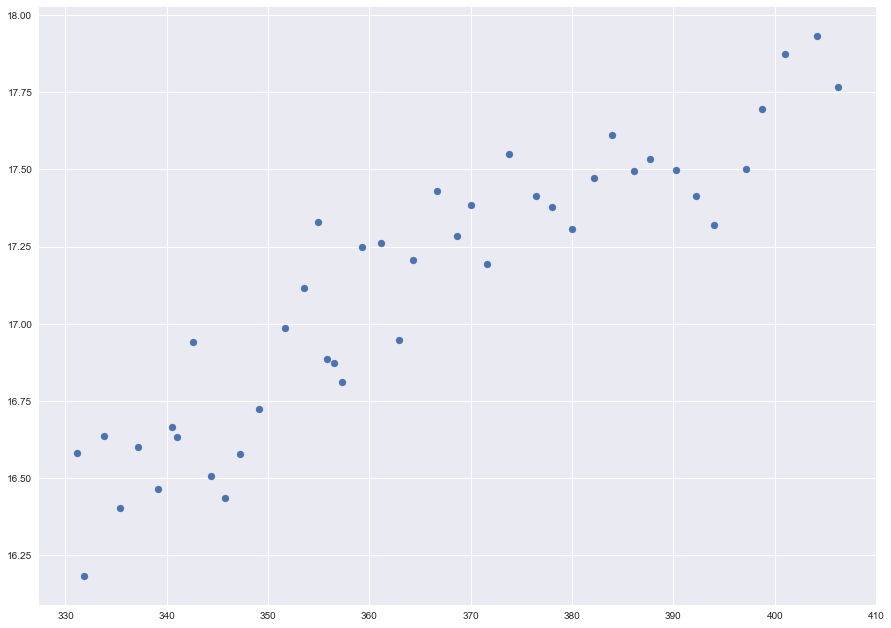

In [54]:
fig, ax = plt.subplots(figsize = (15,11))

ax.scatter('Monthly_Co2','Monthly_Temp', data = temp_co2_GDF )

In [60]:
#Get data for dual Y-Axis chart
t = temp_co2_GDF[['Year']]
data1 = temp_co2_GDF[['Monthly_Temp']]
data2 = temp_co2_GDF[['Monthly_Co2']]


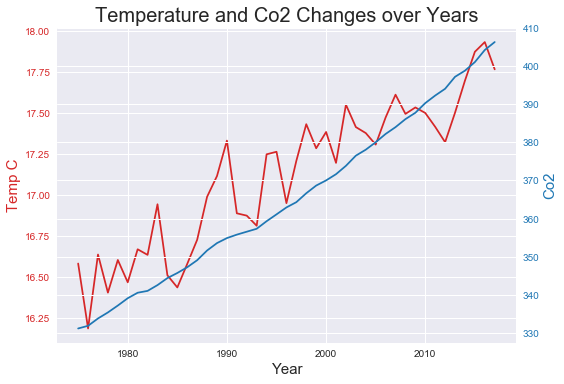

In [75]:
# Create Temp and Co2 on one chart


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year', size=15)
ax1.set_ylabel('Temp. C', color=color, size=15)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Co2', color=color,size=15)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Temperature and Co2 Changes over Years', size=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()